In [1]:
import vaex
vaex.multithreading.thread_count_default = 8
import vaex.ml
import numpy as np
import pylab as plt
from vaex.ml.sklearn import Predictor
from sklearn.ensemble import GradientBoostingClassifier
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
from datetime import datetime
import statistics
import re

In [32]:
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn.metrics import plot_confusion_matrix, f1_score
import xgboost
import vaex.ml.sklearn

# Vaex Modelling: Introduction

Vaex is a python library which is similar to Pandas, but built specifically to explore and work with large tabular datasets. In the grand scheme of things, the dataset being modelled here is not that large, however, it is still large enough to pose a challenge with local modelling. With this project it was a personal goal to use as much of the data as possible, and Vaex enabled me to exhieve exactly this.

Vaex provide a wrapper into Sklearn models, however, there are a handful of models which I discovered with research work particularily well. These models are XGBoost, LogisticRegressions and Support Vector Classifiers. Unfortunately due to time constraints, and wanting to also model without Vaex and instead use subsampling, only XGBoost is used below.

Models 1, 2 and 3 are run using without using SMOTE to solve class imbalances, and Model 4 uses SMOTE to create a class balance, bringing the total observations to model up to ~268k observations.

### Imports and Setting the Scene

In [3]:
vaex_df = vaex.from_csv('to_model2.csv', convert=True)

In [4]:
vaex_df.info()

column,type,unit,description,expression
Unnamed: 0,int64,,,
id,int64,,,
year,int64,,,
active_year,str,,,
type_of_violence,str,,,
conflict_new_id,int64,,,
conflict_name,str,,,
dyad_new_id,int64,,,
dyad_name,str,,,
side_a_new_id,int64,,,


In [5]:
vaex_df.drop('Unnamed: 0', inplace=True)

#,id,year,active_year,type_of_violence,conflict_new_id,conflict_name,dyad_new_id,dyad_name,side_a_new_id,side_a,side_b_new_id,side_b,source_original,where_coordinates,where_description,adm_1,latitude,longitude,priogrid_gid,country,region,deaths_unknown,conflict_length,capital_investment,economic_growth,savings_pcnt_gdp,inflation,pcnt_world_tourist_arrivals,death_rate_p1000,human_flight_brain_drain_index_score,government_debt,inv_freedom_index_score,external_debt,labor_freedom_index_score,remittances,pop_growth_pcnt,banking_z_score,oil_reserves_barrels,pcnt_world_oil_reserves,oil_prod_barrels_daily,trade_balance,media_org_source,incident_classification
0,244657,2017,Part of an Ongoing Conflict,State-Based Conflict,259,Iraq: Government,524,Government of Iraq - IS,116,Government of Iraq,234,IS,"IS, interior ministry, security source",Kabul city,Iraqi embassy in Kabul,Kabul province,34.531094,69.162796,179779,Afghanistan,Asia,2,0,0.0,2.65,0.0,5.0,0.0,6.57,8.2,8.0,55.0,14.39,60.0,4.36,2.55,11.5,0.0,0.0,0.0,0.0,Agence France Presse,1
1,233552,2017,Part of an Ongoing Conflict,State-Based Conflict,333,Afghanistan: Government,735,Government of Afghanistan - Taleban,130,Government of Afghanistan,303,Taleban,"provincial governor, Taleban",Taghaye Khwajasufla village,'Taghai-Khwaj and Tabir localities of Sangcharak...,Sari Pul province,35.9654,66.3691,181213,Afghanistan,Asia,0,0,0.0,2.65,0.0,5.0,0.0,6.57,8.2,8.0,55.0,14.39,60.0,4.36,2.55,11.5,0.0,0.0,0.0,0.0,Xinhua News Agency,1
2,233553,2017,Part of an Ongoing Conflict,State-Based Conflict,333,Afghanistan: Government,735,Government of Afghanistan - Taleban,130,Government of Afghanistan,303,Taleban,provincial governor,Sari Pul-Jawzjan road (Sari Pul province),'a road connecting Saripul to the neighboring Ja...,Sari Pul province,36.306238,65.890063,181932,Afghanistan,Asia,0,0,0.0,2.65,0.0,5.0,0.0,6.57,8.2,8.0,55.0,14.39,60.0,4.36,2.55,11.5,0.0,0.0,0.0,0.0,Xinhua News Agency,1
3,233554,2017,Part of an Ongoing Conflict,State-Based Conflict,333,Afghanistan: Government,735,Government of Afghanistan - Taleban,130,Government of Afghanistan,303,Taleban,"Interior Ministry, governor’s spokesman, resident",Abjosh Bala village,Ab Josh area of Charkh district of Logar province,Logar province,33.8471,68.8296,178338,Afghanistan,Asia,0,0,0.0,2.65,0.0,5.0,0.0,6.57,8.2,8.0,55.0,14.39,60.0,4.36,2.55,11.5,0.0,0.0,0.0,0.0,Xinhua News Agency,2
4,237882,2017,Part of an Ongoing Conflict,State-Based Conflict,333,Afghanistan: Government,735,Government of Afghanistan - Taleban,130,Government of Afghanistan,303,Taleban,"'administrative chief of Marja district, Militar...",Marja town,"Marja district centre, Hilmand",Hilmand province,31.521994,64.118492,175449,Afghanistan,Asia,0,0,0.0,2.65,0.0,5.0,0.0,6.57,8.2,8.0,55.0,14.39,60.0,4.36,2.55,11.5,0.0,0.0,0.0,0.0,Pajhwok News,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"168,349",335285,2019,Isolated Incident,One-Sided Violence,447,Government of Venezuela - Civilians,914,Government of Venezuela - Civilians,18,Government of Venezuela,1,Civilians,residents,Caracas city,"""Jose Felix Ribas, a district within Caracas' sp...",Distrito Capital,10.488011,-66.879193,144227,Venezuela,Americas,0,0,26.04,-1.27,13.98,188.3,0.04,7.12,6.1,232.79,5.0,38.29,28.0,0.0,-1.66,3.51,302.81,18.23,876.82,-9.72,Reuters News,0
"168,350",335286,2019,Isolated Incident,One-Sided Violence,447,Government of Venezuela - Civilians,914,Government of Venezuela - Civilians,18,Government of Venezuela,1,Civilians,Witnesses,Carora town,Carora town,Lara state,10.172834,-70.081003,144220,Venezuela,Americas,0,0,26.04,-1.27,13.98,188.3,0.04,7.12,6.1,232.79,5.0,38.29,28.0,0.0,-1.66,3.51,302.81,18.23,876.82,-9.72,Amnesty,0
"168,351",285541,2019,Isolated Incident,One-Sided Violence,606,ELN - Civilians,1073,ELN - Civilians,744,ELN,1,Civilians,El Nacional Online,Ureña town,"'Urena and La

In [6]:
## Here we see the class imbalance

vaex_df.incident_classification.value_counts()

0    95707
1    56026
2    16113
3      508
dtype: int64

In [7]:
vaex_df.drop('deaths_unknown', inplace=True)

#,id,year,active_year,type_of_violence,conflict_new_id,conflict_name,dyad_new_id,dyad_name,side_a_new_id,side_a,side_b_new_id,side_b,source_original,where_coordinates,where_description,adm_1,latitude,longitude,priogrid_gid,country,region,conflict_length,capital_investment,economic_growth,savings_pcnt_gdp,inflation,pcnt_world_tourist_arrivals,death_rate_p1000,human_flight_brain_drain_index_score,government_debt,inv_freedom_index_score,external_debt,labor_freedom_index_score,remittances,pop_growth_pcnt,banking_z_score,oil_reserves_barrels,pcnt_world_oil_reserves,oil_prod_barrels_daily,trade_balance,media_org_source,incident_classification
0,244657,2017,Part of an Ongoing Conflict,State-Based Conflict,259,Iraq: Government,524,Government of Iraq - IS,116,Government of Iraq,234,IS,"IS, interior ministry, security source",Kabul city,Iraqi embassy in Kabul,Kabul province,34.531094,69.162796,179779,Afghanistan,Asia,0,0.0,2.65,0.0,5.0,0.0,6.57,8.2,8.0,55.0,14.39,60.0,4.36,2.55,11.5,0.0,0.0,0.0,0.0,Agence France Presse,1
1,233552,2017,Part of an Ongoing Conflict,State-Based Conflict,333,Afghanistan: Government,735,Government of Afghanistan - Taleban,130,Government of Afghanistan,303,Taleban,"provincial governor, Taleban",Taghaye Khwajasufla village,'Taghai-Khwaj and Tabir localities of Sangcharak...,Sari Pul province,35.9654,66.3691,181213,Afghanistan,Asia,0,0.0,2.65,0.0,5.0,0.0,6.57,8.2,8.0,55.0,14.39,60.0,4.36,2.55,11.5,0.0,0.0,0.0,0.0,Xinhua News Agency,1
2,233553,2017,Part of an Ongoing Conflict,State-Based Conflict,333,Afghanistan: Government,735,Government of Afghanistan - Taleban,130,Government of Afghanistan,303,Taleban,provincial governor,Sari Pul-Jawzjan road (Sari Pul province),'a road connecting Saripul to the neighboring Ja...,Sari Pul province,36.306238,65.890063,181932,Afghanistan,Asia,0,0.0,2.65,0.0,5.0,0.0,6.57,8.2,8.0,55.0,14.39,60.0,4.36,2.55,11.5,0.0,0.0,0.0,0.0,Xinhua News Agency,1
3,233554,2017,Part of an Ongoing Conflict,State-Based Conflict,333,Afghanistan: Government,735,Government of Afghanistan - Taleban,130,Government of Afghanistan,303,Taleban,"Interior Ministry, governor’s spokesman, resident",Abjosh Bala village,Ab Josh area of Charkh district of Logar province,Logar province,33.8471,68.8296,178338,Afghanistan,Asia,0,0.0,2.65,0.0,5.0,0.0,6.57,8.2,8.0,55.0,14.39,60.0,4.36,2.55,11.5,0.0,0.0,0.0,0.0,Xinhua News Agency,2
4,237882,2017,Part of an Ongoing Conflict,State-Based Conflict,333,Afghanistan: Government,735,Government of Afghanistan - Taleban,130,Government of Afghanistan,303,Taleban,"'administrative chief of Marja district, Militar...",Marja town,"Marja district centre, Hilmand",Hilmand province,31.521994,64.118492,175449,Afghanistan,Asia,0,0.0,2.65,0.0,5.0,0.0,6.57,8.2,8.0,55.0,14.39,60.0,4.36,2.55,11.5,0.0,0.0,0.0,0.0,Pajhwok News,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"168,349",335285,2019,Isolated Incident,One-Sided Violence,447,Government of Venezuela - Civilians,914,Government of Venezuela - Civilians,18,Government of Venezuela,1,Civilians,residents,Caracas city,"""Jose Felix Ribas, a district within Caracas' sp...",Distrito Capital,10.488011,-66.879193,144227,Venezuela,Americas,0,26.04,-1.27,13.98,188.3,0.04,7.12,6.1,232.79,5.0,38.29,28.0,0.0,-1.66,3.51,302.81,18.23,876.82,-9.72,Reuters News,0
"168,350",335286,2019,Isolated Incident,One-Sided Violence,447,Government of Venezuela - Civilians,914,Government of Venezuela - Civilians,18,Government of Venezuela,1,Civilians,Witnesses,Carora town,Carora town,Lara state,10.172834,-70.081003,144220,Venezuela,Americas,0,26.04,-1.27,13.98,188.3,0.04,7.12,6.1,232.79,5.0,38.29,28.0,0.0,-1.66,3.51,302.81,18.23,876.82,-9.72,Amnesty,0
"168,351",285541,2019,Isolated Incident,One-Sided Violence,606,ELN - Civilians,1073,ELN - Civilians,744,ELN,1,Civilians,El Nacional Online,Ureña town,"'Urena and La Fria (Tachira), located on the C

In [8]:
## Shuffling the data to ensure randomly fed into model
vaex_df.shuffle().export("vaex_shuffled.hdf5")
vaex_df = vaex.open("vaex_shuffled.hdf5")
vaex_train, vaex_test = vaex_df.ml.train_test_split(test_size=0.2)

C:\ProgramData\Anaconda3\lib\site-packages\vaex\ml\__init__.py:31: UserWarning: Make sure the DataFrame is shuffled
  warnings.warn('Make sure the DataFrame is shuffled')


### Encoding Categorical Variables & Model 1

One of the challenges the dataset presented with modelling was the number of categorical variables, but more specifically the cardinality of the variables. Using One Hot Encoder very quickly lead to an unmanagably large feature space, so where possible I used the frequency and label encoders.

##### Encoding Train Data

In [9]:
frequency_encoder = vaex.ml.FrequencyEncoder(features=['conflict_name', 'dyad_name', 'side_a', 'side_b', 'source_original', 'where_coordinates', 'where_description', 'adm_1', 'country', 'media_org_source'], allow_unseen=True)
vaex_train = frequency_encoder.fit_transform(vaex_train)

In [10]:
label_encoder = vaex.ml.LabelEncoder(features=['active_year', 'type_of_violence', 'region'])
vaex_train = label_encoder.fit_transform(vaex_train)

##### Encoding Test Data

In [11]:
frequency_encoder = vaex.ml.FrequencyEncoder(features=['conflict_name', 'dyad_name', 'side_a', 'side_b', 'source_original', 'where_coordinates', 'where_description', 'adm_1', 'country', 'media_org_source'], allow_unseen=True)
vaex_test = frequency_encoder.fit_transform(vaex_test)

In [12]:
label_encoder = vaex.ml.LabelEncoder(features=['active_year', 'type_of_violence', 'region'])
vaex_test = label_encoder.fit_transform(vaex_test)

##### Specify Predictors

Vaex follows a slightly different structure for modelling, where you split a core dataset into a test and train set, keeping X and Y in same frame, but then when creating the actual model you specify the feature columns and the target column to be used from the train and test set.

In [13]:
vaex_train.info()

column,type,unit,description,expression
id,int64,,,
year,int64,,,
active_year,str,,,
type_of_violence,str,,,
conflict_new_id,int64,,,
conflict_name,str,,,
dyad_new_id,int64,,,
dyad_name,str,,,
side_a_new_id,int64,,,
side_a,str,,,


In [14]:
features = ['frequency_encoded_conflict_name', 'frequency_encoded_dyad_name', 'frequency_encoded_side_a', 
         'frequency_encoded_side_b', 'frequency_encoded_source_original', 'frequency_encoded_where_coordinates',
         'frequency_encoded_where_description', 'frequency_encoded_adm_1', 'frequency_encoded_country',
         'frequency_encoded_media_org_source', 'label_encoded_active_year', 'label_encoded_type_of_violence',
         'label_encoded_region', 'id', 'year', 'conflict_new_id', 'dyad_new_id', 'side_a_new_id', 'side_b_new_id',
         'latitude', 'longitude', 'priogrid_gid', 'conflict_length', 'capital_investment',
         'economic_growth', 'savings_pcnt_gdp', 'inflation', 'pcnt_world_tourist_arrivals', 'death_rate_p1000',
         'human_flight_brain_drain_index_score', 'government_debt', 'inv_freedom_index_score', 'external_debt',
         'labor_freedom_index_score', 'remittances', 'pop_growth_pcnt', 'banking_z_score', 'oil_reserves_barrels',
         'pcnt_world_oil_reserves', 'oil_prod_barrels_daily', 'trade_balance']

##### Scaling Features

In [15]:
## Training Data

scaler = vaex.ml.StandardScaler(features=features)
scaler.fit(vaex_train)
vaex_train = scaler.transform(vaex_train)
vaex_train


#,id,year,active_year,type_of_violence,conflict_new_id,conflict_name,dyad_new_id,dyad_name,side_a_new_id,side_a,side_b_new_id,side_b,source_original,where_coordinates,where_description,adm_1,latitude,longitude,priogrid_gid,country,region,conflict_length,capital_investment,economic_growth,savings_pcnt_gdp,inflation,pcnt_world_tourist_arrivals,death_rate_p1000,human_flight_brain_drain_index_score,government_debt,inv_freedom_index_score,external_debt,labor_freedom_index_score,remittances,pop_growth_pcnt,banking_z_score,oil_reserves_barrels,pcnt_world_oil_reserves,oil_prod_barrels_daily,trade_balance,media_org_source,incident_classification,frequency_encoded_conflict_name,frequency_encoded_dyad_name,frequency_encoded_side_a,frequency_encoded_side_b,frequency_encoded_source_original,frequency_encoded_where_coordinates,frequency_encoded_where_description,frequency_encoded_adm_1,frequency_encoded_country,frequency_encoded_media_org_source,label_encoded_active_year,label_encoded_type_of_violence,label_encoded_region,standard_scaled_frequency_encoded_conflict_name,standard_scaled_frequency_encoded_dyad_name,standard_scaled_frequency_encoded_side_a,standard_scaled_frequency_encoded_side_b,standard_scaled_frequency_encoded_source_original,standard_scaled_frequency_encoded_where_coordinates,standard_scaled_frequency_encoded_where_description,standard_scaled_frequency_encoded_adm_1,standard_scaled_frequency_encoded_country,standard_scaled_frequency_encoded_media_org_source,standard_scaled_label_encoded_active_year,standard_scaled_label_encoded_type_of_violence,standard_scaled_label_encoded_region,standard_scaled_id,standard_scaled_year,standard_scaled_conflict_new_id,standard_scaled_dyad_new_id,standard_scaled_side_a_new_id,standard_scaled_side_b_new_id,standard_scaled_latitude,standard_scaled_longitude,standard_scaled_priogrid_gid,standard_scaled_conflict_length,standard_scaled_capital_investment,standard_scaled_economic_growth,standard_scaled_savings_pcnt_gdp,standard_scaled_inflation,standard_scaled_pcnt_world_tourist_arrivals,standard_scaled_death_rate_p1000,standard_scaled_human_flight_brain_drain_index_score,standard_scaled_government_debt,standard_scaled_inv_freedom_index_score,standard_scaled_external_debt,standard_scaled_labor_freedom_index_score,standard_scaled_remittances,standard_scaled_pop_growth_pcnt,standard_scaled_banking_z_score,standard_scaled_oil_reserves_barrels,standard_scaled_pcnt_world_oil_reserves,standard_scaled_oil_prod_barrels_daily,standard_scaled_trade_balance
0,326304,2013,Part of an Ongoing Conflict,State-Based Conflict,299,Syria: Government,11973,Government of Syria - Syrian insurgents,118,Government of Syria,4456,Syrian insurgents,SOHR,Damascus city,"Damascus and Reef Dimashq,",Damascus governorate,33.513364,36.291575,178273,Syria,Middle East,0,26.16,5.7,29.46,20.75,0.73,5.51,6.2,0.0,10.0,0.0,49.0,2.55,-4.29,5.17,2.5,0.15,58.04,2.6,Support Kurds in Syria,1,0.35022979886102923,0.35022979886102923,0.39199453531626116,0.35022979886102923,0.22091874995359473,0.019913426341854577,1.4849684072971347e-05,0.019957975394073492,0.4520986316016127,0.03693858913151623,0,0,0,1.2560752472651298,1.2567770745137663,1.162438933701689,1.2533867781739194,1.7025056966700949,3.5196789395991877,-0.29232874116909124,-0.30367092695876224,1.0460410181698643,-0.4953915408101696,-0.15237165454037568,-0.49845369186578176,-0.813924086246777,0.8730652336042676,-0.371611979681008,-0.4942320508581076,0.7653257755902877,-0.25828144398006353,0.9619330696705394,0.3954880742798763,-0.09648833686264478,0.4152182518518813,-0.08195931603385788,0.5923395133801028,0.20375907382715938,0.6045213167431813,0.6324141331873719,0.2460990794230242,-0.09269064228503054,-0.7852799374065493,-0.66338421903607,-0.8113639493553084,-0.6622442296531786,-0.10503680140929757,-0.0808495479124352,-1.3057934793872443,-0.863339706532769,-0.20757901420956654,-0.213370970750503,-0.3544207459437686,0.31848146502586566
1,212509,2015,Part of an Ongoing Conflict,State-Based 

In [16]:
## Test Data

scaler = vaex.ml.StandardScaler(features=features)
scaler.fit(vaex_test)
vaex_test = scaler.transform(vaex_test)
vaex_test


#,id,year,active_year,type_of_violence,conflict_new_id,conflict_name,dyad_new_id,dyad_name,side_a_new_id,side_a,side_b_new_id,side_b,source_original,where_coordinates,where_description,adm_1,latitude,longitude,priogrid_gid,country,region,conflict_length,capital_investment,economic_growth,savings_pcnt_gdp,inflation,pcnt_world_tourist_arrivals,death_rate_p1000,human_flight_brain_drain_index_score,government_debt,inv_freedom_index_score,external_debt,labor_freedom_index_score,remittances,pop_growth_pcnt,banking_z_score,oil_reserves_barrels,pcnt_world_oil_reserves,oil_prod_barrels_daily,trade_balance,media_org_source,incident_classification,frequency_encoded_conflict_name,frequency_encoded_dyad_name,frequency_encoded_side_a,frequency_encoded_side_b,frequency_encoded_source_original,frequency_encoded_where_coordinates,frequency_encoded_where_description,frequency_encoded_adm_1,frequency_encoded_country,frequency_encoded_media_org_source,label_encoded_active_year,label_encoded_type_of_violence,label_encoded_region,standard_scaled_frequency_encoded_conflict_name,standard_scaled_frequency_encoded_dyad_name,standard_scaled_frequency_encoded_side_a,standard_scaled_frequency_encoded_side_b,standard_scaled_frequency_encoded_source_original,standard_scaled_frequency_encoded_where_coordinates,standard_scaled_frequency_encoded_where_description,standard_scaled_frequency_encoded_adm_1,standard_scaled_frequency_encoded_country,standard_scaled_frequency_encoded_media_org_source,standard_scaled_label_encoded_active_year,standard_scaled_label_encoded_type_of_violence,standard_scaled_label_encoded_region,standard_scaled_id,standard_scaled_year,standard_scaled_conflict_new_id,standard_scaled_dyad_new_id,standard_scaled_side_a_new_id,standard_scaled_side_b_new_id,standard_scaled_latitude,standard_scaled_longitude,standard_scaled_priogrid_gid,standard_scaled_conflict_length,standard_scaled_capital_investment,standard_scaled_economic_growth,standard_scaled_savings_pcnt_gdp,standard_scaled_inflation,standard_scaled_pcnt_world_tourist_arrivals,standard_scaled_death_rate_p1000,standard_scaled_human_flight_brain_drain_index_score,standard_scaled_government_debt,standard_scaled_inv_freedom_index_score,standard_scaled_external_debt,standard_scaled_labor_freedom_index_score,standard_scaled_remittances,standard_scaled_pop_growth_pcnt,standard_scaled_banking_z_score,standard_scaled_oil_reserves_barrels,standard_scaled_pcnt_world_oil_reserves,standard_scaled_oil_prod_barrels_daily,standard_scaled_trade_balance
0,35094,2010,Part of an Ongoing Conflict,State-Based Conflict,329,Ethiopia: Ogaden,719,Government of Ethiopia - ONLF,97,Government of Ethiopia,497,ONLF,No Source Specified,Yahyah,"'Yahyah, Kebridehar woreda, Korahe zone, Somali ...",Somali state,6.53667,44.385,139409,Ethiopia,Africa,0,0.0,12.55,32.56,8.1,0.05,0.0,7.5,30.9,25.0,24.43,62.0,1.46,2.78,9.9,0.0,0.0,0.0,0.0,'ONLF Military Communiqu November at http://ww...,0,0.0022868343678536427,0.0022868343678536427,0.006147723560333818,0.0022868343678536427,0.06319978616613703,2.969914763446289e-05,2.969914763446289e-05,0.0025838258441982717,0.007038697989367705,0.00020789403344124023,0,0,1,-1.0164184299370953,-1.0118965582349704,-1.1080478686048707,-1.206849335254182,-0.10146920173721709,-0.4722350672501065,-0.2906784360369922,-0.8521642617713308,-1.2519848921282135,-0.8389445509399603,-0.15348972386039172,-0.5001196300997884,0.07999267141215669,-2.0906384593407727,-1.2648334541122788,-0.48554396095868946,-1.1206986177424856,-0.27456667716247835,-0.7821300961971319,-2.157709083048254,0.11795954021433736,-2.1382050990792374,-0.08482794848298345,-1.7099799707625967,1.7174299588197004,0.8204266314093862,-0.5259994788504975,-0.8004104558565507,-2.0220241177362093,0.36209717957588244,0.4644310886968787,-0.12259957074653587,0.8249001590188244,0.5831636570489341,-0.6475787472700563,1.067788997650186,-0.1602360723753649,-0.31395917460206313,-0.31284507510574844,-0.42816415722224066,0.09832753015549112
1,347391,2014,

##### Model 1

XGB: https://xgboost.readthedocs.io/en/latest/parameter.html

In [17]:
xgb_model = xgboost.sklearn.XGBClassifier(max_depth=11,               # Increasing this value will make the model more complex and more likely to overfit.
                                          objective='multi:softmax',
                                          learning_rate=0.1,          # Boosting learning rate (xgb’s “eta”)
                                          n_estimators=500,           # Number of gradient boosted trees. Equivalent to number of boosting rounds.
                                          subsample=0.75,             # Subsample ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees. and this will prevent overfitting.
                                          colsample_bylevel=1,        # This is a family of parameters for subsampling of columns. range of (0, 1], the default value of 1, and specify the fraction of columns to be subsampled.
                                          colsample_bytree=1,         #  is the subsample ratio of columns when constructing each tree.
                                          scale_pos_weight=1.5,       # Balancing of positive and negative weights.
                                          reg_lambda=1.5,              # Lambda L2 Reg. Higher = More conserv model.
                                          reg_alpha=5,                 # L1 Reg
                                          n_jobs=8,                   # Number of parallel threads used to run xgboost.
                                          random_state=42,
                                          use_label_encoder=True,      # (Deprecated) I seem to need it on True
                                          verbosity=0)

vaex_xgb_model = vaex.ml.sklearn.Predictor(features=features,
                                           target='incident_classification',
                                           model=xgb_model,
                                           prediction_name='xgb_pred')

vaex_xgb_model.fit(vaex_train)
vaex_train = vaex_xgb_model.transform(vaex_train)

vaex_train

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


#,id,year,active_year,type_of_violence,conflict_new_id,conflict_name,dyad_new_id,dyad_name,side_a_new_id,side_a,side_b_new_id,side_b,source_original,where_coordinates,where_description,adm_1,latitude,longitude,priogrid_gid,country,region,conflict_length,capital_investment,economic_growth,savings_pcnt_gdp,inflation,pcnt_world_tourist_arrivals,death_rate_p1000,human_flight_brain_drain_index_score,government_debt,inv_freedom_index_score,external_debt,labor_freedom_index_score,remittances,pop_growth_pcnt,banking_z_score,oil_reserves_barrels,pcnt_world_oil_reserves,oil_prod_barrels_daily,trade_balance,media_org_source,incident_classification,frequency_encoded_conflict_name,frequency_encoded_dyad_name,frequency_encoded_side_a,frequency_encoded_side_b,frequency_encoded_source_original,frequency_encoded_where_coordinates,frequency_encoded_where_description,frequency_encoded_adm_1,frequency_encoded_country,frequency_encoded_media_org_source,label_encoded_active_year,label_encoded_type_of_violence,label_encoded_region,standard_scaled_frequency_encoded_conflict_name,standard_scaled_frequency_encoded_dyad_name,standard_scaled_frequency_encoded_side_a,standard_scaled_frequency_encoded_side_b,standard_scaled_frequency_encoded_source_original,standard_scaled_frequency_encoded_where_coordinates,standard_scaled_frequency_encoded_where_description,standard_scaled_frequency_encoded_adm_1,standard_scaled_frequency_encoded_country,standard_scaled_frequency_encoded_media_org_source,standard_scaled_label_encoded_active_year,standard_scaled_label_encoded_type_of_violence,standard_scaled_label_encoded_region,standard_scaled_id,standard_scaled_year,standard_scaled_conflict_new_id,standard_scaled_dyad_new_id,standard_scaled_side_a_new_id,standard_scaled_side_b_new_id,standard_scaled_latitude,standard_scaled_longitude,standard_scaled_priogrid_gid,standard_scaled_conflict_length,standard_scaled_capital_investment,standard_scaled_economic_growth,standard_scaled_savings_pcnt_gdp,standard_scaled_inflation,standard_scaled_pcnt_world_tourist_arrivals,standard_scaled_death_rate_p1000,standard_scaled_human_flight_brain_drain_index_score,standard_scaled_government_debt,standard_scaled_inv_freedom_index_score,standard_scaled_external_debt,standard_scaled_labor_freedom_index_score,standard_scaled_remittances,standard_scaled_pop_growth_pcnt,standard_scaled_banking_z_score,standard_scaled_oil_reserves_barrels,standard_scaled_pcnt_world_oil_reserves,standard_scaled_oil_prod_barrels_daily,standard_scaled_trade_balance,xgb_pred
0,326304,2013,Part of an Ongoing Conflict,State-Based Conflict,299,Syria: Government,11973,Government of Syria - Syrian insurgents,118,Government of Syria,4456,Syrian insurgents,SOHR,Damascus city,"Damascus and Reef Dimashq,",Damascus governorate,33.513364,36.291575,178273,Syria,Middle East,0,26.16,5.7,29.46,20.75,0.73,5.51,6.2,0.0,10.0,0.0,49.0,2.55,-4.29,5.17,2.5,0.15,58.04,2.6,Support Kurds in Syria,1,0.35022979886102923,0.35022979886102923,0.39199453531626116,0.35022979886102923,0.22091874995359473,0.019913426341854577,1.4849684072971347e-05,0.019957975394073492,0.4520986316016127,0.03693858913151623,0,0,0,1.2560752472651298,1.2567770745137663,1.162438933701689,1.2533867781739194,1.7025056966700949,3.5196789395991877,-0.29232874116909124,-0.30367092695876224,1.0460410181698643,-0.4953915408101696,-0.15237165454037568,-0.49845369186578176,-0.813924086246777,0.8730652336042676,-0.371611979681008,-0.4942320508581076,0.7653257755902877,-0.25828144398006353,0.9619330696705394,0.3954880742798763,-0.09648833686264478,0.4152182518518813,-0.08195931603385788,0.5923395133801028,0.20375907382715938,0.6045213167431813,0.6324141331873719,0.2460990794230242,-0.09269064228503054,-0.7852799374065493,-0.66338421903607,-0.8113639493553084,-0.6622442296531786,-0.10503680140929757,-0.0808495479124352,-1.3057934793872443,-0.863339706532769,-0.20757901420956654,-0.213370970750503,-0.3544207459437686,0.31848146502586566,1
1,212509,2015,Part of an Ongoing Conflict,S

In [18]:
y_true = vaex_train.incident_classification.values
y_pred = vaex_train.xgb_pred.values

In [19]:
accuracy_score(y_true, y_pred)

0.8275431940185473

In [26]:
f1_score(y_true, y_pred, average='weighted')

0.8229529327291606

##### Vaex State
"Vaex keeps track of all the changes one applies to a DataFrame in something called a state. A state is the place which contains all the informations regarding, for instance, the virtual columns we’ve created, which includes the newly engineered features, the categorically encoded columns, and even the model prediction"

###### Test Results:

In [27]:
state = vaex_train.state_get()  #Get the state from Train data
vaex_test.state_set(state) # Apply state to Test data

In [28]:
y_test_true = vaex_test.incident_classification.values
y_test_pred = vaex_test.xgb_pred.values

In [29]:
print("Model 1 Test Accuracy Score: ", accuracy_score(y_test_true, y_test_pred))
print("Model 1 Test F1 Score: ", f1_score(y_test_true, y_test_pred, average='weighted'))

Model 1 Test Accuracy Score:  0.649045172403552
Model 1 Test F1 Score:  0.634430119444292


In [30]:
print(metrics.classification_report(y_test_true, y_test_pred))

              precision    recall  f1-score   support

           0       0.71      0.82      0.77     19217
           1       0.54      0.46      0.50     11133
           2       0.46      0.28      0.35      3221
           3       0.51      0.23      0.32       100

    accuracy                           0.65     33671
   macro avg       0.56      0.45      0.48     33671
weighted avg       0.63      0.65      0.63     33671



In [31]:
print(f'Confusion Matrix: \n{confusion_matrix(y_test_true, y_test_pred)}')

Confusion Matrix: 
[[15814  3062   339     2]
 [ 5337  5123   670     3]
 [  947  1363   894    17]
 [   24    12    41    23]]


###### Result: 
Not bad considering the baseline accuracy with unbalanced classes is 56.84%.

#### XGB Model 2 - Parameter Tuning

In [35]:
vaex_train2, vaex_test2 = vaex_df.ml.train_test_split(test_size=0.2)

C:\ProgramData\Anaconda3\lib\site-packages\vaex\ml\__init__.py:31: UserWarning: Make sure the DataFrame is shuffled
  warnings.warn('Make sure the DataFrame is shuffled')


In [ ]:
#vaex_test2.drop('xgb_pred', inplace=True)
#vaex_train2.drop('xgb_pred', inplace=True)

#### Parameter Tuning Results:

* Increasing n_estimators to 800: Moderate increase in Training scores, Slight drop in Test scores.
* Setting Objective to multi:softprob = No major change in results.
* Following suggestion in documentation to set "num_class" with multi:softmax = No change.
* Dropping lambda to 1 from 1.5 = Test scores dropping by approx 0.002
* Dropping lambda to 0 from 1 = Test scores remain the same
* Increasing Lambda from 1.5 to 5 = no measurable impact
* Increasing alpha from 5 to 10 = Test Scores increase by 0.001, Train scores drop to ~0.77
* Increasing alpha from 10 to 20 = Test scores drop by 0.001, Train scores drop by around ~0.5
* Increasing Lambda to 20 and n_estimators to 700 from 500 = very small decrease in test scores.
* Increasing max depth from 12 to 15 = Train Scores increase to 0.9, Test scores drop ~0.005 for both Accuracy and F1
* Increasing depth to 20 and alpha to 20 = Test Accuracy up to 0.646 from 0.639
* Increased learning_rate from 0.1 to 0.3 = Test Accuracy drops from 0.646 to 0.642

#### Encoding Train Data

In [37]:
frequency_encoder = vaex.ml.FrequencyEncoder(features=['conflict_name', 'dyad_name', 'side_a', 'side_b', 'source_original', 'where_coordinates', 'where_description', 'adm_1', 'country', 'media_org_source'], allow_unseen=True)
vaex_train2 = frequency_encoder.fit_transform(vaex_train2)

label_encoder = vaex.ml.LabelEncoder(features=['active_year', 'type_of_violence', 'region'])
vaex_train2 = label_encoder.fit_transform(vaex_train2)


#### Encoding Test Data

In [38]:
frequency_encoder = vaex.ml.FrequencyEncoder(features=['conflict_name', 'dyad_name', 'side_a', 'side_b', 'source_original', 'where_coordinates', 'where_description', 'adm_1', 'country', 'media_org_source'], allow_unseen=True)
vaex_test2 = frequency_encoder.fit_transform(vaex_test2)

In [39]:
label_encoder = vaex.ml.LabelEncoder(features=['active_year', 'type_of_violence', 'region'])
vaex_test2 = label_encoder.fit_transform(vaex_test2)

##### Scaling Features

In [40]:
## Training Data

scaler = vaex.ml.StandardScaler(features=features)
scaler.fit(vaex_train2)
vaex_train2 = scaler.transform(vaex_train2)

In [41]:
## Test Data

scaler = vaex.ml.StandardScaler(features=features)
scaler.fit(vaex_test2)
vaex_test2 = scaler.transform(vaex_test2)

In [42]:
xgb_model2 = xgboost.sklearn.XGBClassifier(max_depth=20,               # Increasing this value will make the model more complex and more likely to overfit.
                                          objective='multi:softmax',
                                          learning_rate=0.3,          # Boosting learning rate (xgb’s “eta”)
                                          n_estimators=500,           # Number of gradient boosted trees. Equivalent to number of boosting rounds.
                                          subsample=0.75,             # Subsample ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees. Prevent overfitting.
                                          colsample_bylevel=1,        # This is a family of parameters for subsampling of columns. range of (0, 1], the default value of 1, and specify the fraction of columns to be subsampled.
                                          colsample_bytree=1,         #  is the subsample ratio of columns when constructing each tree.
                                          scale_pos_weight=1.5,       # Balancing of positive and negative weights.
                                          reg_lambda=1.5,              # Lambda L2 Reg. Higher = More conserv model.
                                          reg_alpha=20,                 # L1 Reg
                                          n_jobs=8,                   # Number of parallel threads used to run xgboost.
                                          random_state=42,
                                          use_label_encoder=True,      # (Deprecated) I seem to need it on True
                                          verbosity=1)

vaex_xgb_model = vaex.ml.sklearn.Predictor(features=features,
                                           target='incident_classification',
                                           model=xgb_model2,
                                           prediction_name='xgb_pred')

vaex_xgb_model.fit(vaex_train2)
vaex_train2 = vaex_xgb_model.transform(vaex_train2)

vaex_train2

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:51:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "scale_pos_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:51:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


#,id,year,active_year,type_of_violence,conflict_new_id,conflict_name,dyad_new_id,dyad_name,side_a_new_id,side_a,side_b_new_id,side_b,source_original,where_coordinates,where_description,adm_1,latitude,longitude,priogrid_gid,country,region,conflict_length,capital_investment,economic_growth,savings_pcnt_gdp,inflation,pcnt_world_tourist_arrivals,death_rate_p1000,human_flight_brain_drain_index_score,government_debt,inv_freedom_index_score,external_debt,labor_freedom_index_score,remittances,pop_growth_pcnt,banking_z_score,oil_reserves_barrels,pcnt_world_oil_reserves,oil_prod_barrels_daily,trade_balance,media_org_source,incident_classification,frequency_encoded_conflict_name,frequency_encoded_dyad_name,frequency_encoded_side_a,frequency_encoded_side_b,frequency_encoded_source_original,frequency_encoded_where_coordinates,frequency_encoded_where_description,frequency_encoded_adm_1,frequency_encoded_country,frequency_encoded_media_org_source,label_encoded_active_year,label_encoded_type_of_violence,label_encoded_region,standard_scaled_frequency_encoded_conflict_name,standard_scaled_frequency_encoded_dyad_name,standard_scaled_frequency_encoded_side_a,standard_scaled_frequency_encoded_side_b,standard_scaled_frequency_encoded_source_original,standard_scaled_frequency_encoded_where_coordinates,standard_scaled_frequency_encoded_where_description,standard_scaled_frequency_encoded_adm_1,standard_scaled_frequency_encoded_country,standard_scaled_frequency_encoded_media_org_source,standard_scaled_label_encoded_active_year,standard_scaled_label_encoded_type_of_violence,standard_scaled_label_encoded_region,standard_scaled_id,standard_scaled_year,standard_scaled_conflict_new_id,standard_scaled_dyad_new_id,standard_scaled_side_a_new_id,standard_scaled_side_b_new_id,standard_scaled_latitude,standard_scaled_longitude,standard_scaled_priogrid_gid,standard_scaled_conflict_length,standard_scaled_capital_investment,standard_scaled_economic_growth,standard_scaled_savings_pcnt_gdp,standard_scaled_inflation,standard_scaled_pcnt_world_tourist_arrivals,standard_scaled_death_rate_p1000,standard_scaled_human_flight_brain_drain_index_score,standard_scaled_government_debt,standard_scaled_inv_freedom_index_score,standard_scaled_external_debt,standard_scaled_labor_freedom_index_score,standard_scaled_remittances,standard_scaled_pop_growth_pcnt,standard_scaled_banking_z_score,standard_scaled_oil_reserves_barrels,standard_scaled_pcnt_world_oil_reserves,standard_scaled_oil_prod_barrels_daily,standard_scaled_trade_balance,xgb_pred
0,326304,2013,Part of an Ongoing Conflict,State-Based Conflict,299,Syria: Government,11973,Government of Syria - Syrian insurgents,118,Government of Syria,4456,Syrian insurgents,SOHR,Damascus city,"Damascus and Reef Dimashq,",Damascus governorate,33.513364,36.291575,178273,Syria,Middle East,0,26.16,5.7,29.46,20.75,0.73,5.51,6.2,0.0,10.0,0.0,49.0,2.55,-4.29,5.17,2.5,0.15,58.04,2.6,Support Kurds in Syria,1,0.35022979886102923,0.35022979886102923,0.39199453531626116,0.35022979886102923,0.22091874995359473,0.019913426341854577,1.4849684072971347e-05,0.019957975394073492,0.4520986316016127,0.03693858913151623,0,0,0,1.2560752472651298,1.2567770745137665,1.1624389337016892,1.2533867781739194,1.7025056966700949,3.5196789395991877,-0.2923287411690913,-0.3036709269587624,1.0460410181698643,-0.4953915408101695,-0.15237165454037568,-0.5038391265626665,-0.7578850764843217,0.8730652336042676,-0.371611979681008,-0.4942320508581076,0.7653257755902877,-0.25828144398006353,0.9619330696705394,0.3954880742798763,-0.0964883368626448,0.4152182518518813,-0.08195931603385788,0.5923395133801026,0.20375907382715938,0.6045213167431813,0.6324141331873717,0.2460990794230242,-0.09269064228503054,-0.7852799374065413,-0.66338421903607,-0.8113639493553084,-0.6622442296531788,-0.10503680140929757,-0.0808495479124352,-1.3057934793872443,-0.8633397065327688,-0.20757901420956656,-0.21337097075050293,-0.3544207459437685,0.31848146502586566,1
1,212509,2015,Part of an Ongoing Conflict,

In [43]:
y_true2 = vaex_train2.incident_classification.values
y_pred2 = vaex_train2.xgb_pred.values

In [44]:
print("Model 2 Training Accuracy Score: ", accuracy_score(y_true2, y_pred2))
print("Model 2 Training F1 Score: ", f1_score(y_true2, y_pred2, average='weighted'))

Model 2 Training Accuracy Score:  0.7869738571311895
Model 2 Training F1 Score:  0.7794092132100345


###### Test Results:

In [45]:
state = vaex_train2.state_get()  #Get the state from Train data
vaex_test2.state_set(state) # Apply state to Test data

In [46]:
y_test2_true = vaex_test2.incident_classification.values
y_test2_pred = vaex_test2.xgb_pred.values

In [47]:
print("Model 3 Test Accuracy Score: ", accuracy_score(y_test2_true, y_test2_pred))
print("Model 3 Test F1 Score: ", f1_score(y_test2_true, y_test2_pred, average='weighted'))

Model 3 Test Accuracy Score:  0.6456891687208577
Model 3 Test F1 Score:  0.6302406962522199


In [48]:
print(metrics.classification_report(y_test2_true, y_test2_pred))

              precision    recall  f1-score   support

           0       0.71      0.82      0.76     19217
           1       0.53      0.45      0.49     11133
           2       0.47      0.27      0.35      3221
           3       0.50      0.18      0.26       100

    accuracy                           0.65     33671
   macro avg       0.55      0.43      0.47     33671
weighted avg       0.63      0.65      0.63     33671



In [49]:
print(f'Confusion Matrix: \n{confusion_matrix(y_test2_true, y_test2_pred)}')

Confusion Matrix: 
[[15813  3075   326     3]
 [ 5461  5025   644     3]
 [  976  1348   885    12]
 [   22    15    45    18]]


### XGB Model  3

Because I am slightly suspicious of the high scores, I am running a model below where I remove a few of the variables which I thought might be causing issues.

In [50]:
## I beliebe this is an unecessary step as we specify the features to use in the model below. However,
## I am dropping just to be certain.

vaex_df3 = vaex_df.drop('latitude', inplace=True)
vaex_df3 = vaex_df.drop('longitude', inplace=True)

In [51]:
vaex_df3 = vaex_df.drop('id', inplace=True)

In [52]:
vaex_train3, vaex_test3 = vaex_df3.ml.train_test_split(test_size=0.2)

C:\ProgramData\Anaconda3\lib\site-packages\vaex\ml\__init__.py:31: UserWarning: Make sure the DataFrame is shuffled
  warnings.warn('Make sure the DataFrame is shuffled')


#### Encoding Train Data

In [53]:
frequency_encoder = vaex.ml.FrequencyEncoder(features=['conflict_name', 'dyad_name', 'side_a', 'side_b', 'source_original', 'where_coordinates', 'where_description', 'adm_1', 'country', 'media_org_source'], allow_unseen=True)
vaex_train3 = frequency_encoder.fit_transform(vaex_train3)

In [54]:
label_encoder = vaex.ml.LabelEncoder(features=['active_year', 'type_of_violence', 'region'])
vaex_train3 = label_encoder.fit_transform(vaex_train3)

#### Encoding Test Data

In [55]:
frequency_encoder = vaex.ml.FrequencyEncoder(features=['conflict_name', 'dyad_name', 'side_a', 'side_b', 'source_original', 'where_coordinates', 'where_description', 'adm_1', 'country', 'media_org_source'], allow_unseen=True)
vaex_test3 = frequency_encoder.fit_transform(vaex_test3)

In [56]:
label_encoder = vaex.ml.LabelEncoder(features=['active_year', 'type_of_violence', 'region'])
vaex_test3 = label_encoder.fit_transform(vaex_test3)

In [57]:
features3 = ['frequency_encoded_conflict_name', 'frequency_encoded_dyad_name', 'frequency_encoded_side_a', 
         'frequency_encoded_side_b', 'frequency_encoded_source_original', 'frequency_encoded_where_coordinates',
         'frequency_encoded_where_description', 'frequency_encoded_adm_1', 'frequency_encoded_country',
         'frequency_encoded_media_org_source', 'label_encoded_active_year', 'label_encoded_type_of_violence',
         'label_encoded_region', 'year', 'conflict_new_id', 'dyad_new_id', 'side_a_new_id', 'side_b_new_id',
         'priogrid_gid', 'conflict_length', 'capital_investment','economic_growth', 'savings_pcnt_gdp', 'inflation', 
         'pcnt_world_tourist_arrivals', 'death_rate_p1000', 'human_flight_brain_drain_index_score', 'government_debt', 'inv_freedom_index_score', 'external_debt',
         'labor_freedom_index_score', 'remittances', 'pop_growth_pcnt', 'banking_z_score', 'oil_reserves_barrels',
         'pcnt_world_oil_reserves', 'oil_prod_barrels_daily', 'trade_balance']

##### Scaling Features

In [58]:
## Training Data

scaler = vaex.ml.StandardScaler(features=features3)
scaler.fit(vaex_train3)
vaex_train3 = scaler.transform(vaex_train3)

In [59]:
## Test Data

scaler = vaex.ml.StandardScaler(features=features3)
scaler.fit(vaex_test3)
vaex_test3 = scaler.transform(vaex_test3)

#### Model 3

In [60]:
xgb_model3 = xgboost.sklearn.XGBClassifier(max_depth=11,
                                          objective='multi:softmax',
                                          learning_rate=0.1,
                                          n_estimators=500,
                                          subsample=0.75,
                                          colsample_bylevel=1,
                                          colsample_bytree=1,
                                          scale_pos_weight=1.5,
                                          reg_lambda=1.5,
                                          reg_alpha=5,
                                          n_jobs=8,
                                          random_state=42,
                                          use_label_encoder=True,
                                          verbosity=0)

vaex_xgb_model = vaex.ml.sklearn.Predictor(features=features3,
                                           target='incident_classification',
                                           model=xgb_model3,
                                           prediction_name='xgb_pred')

vaex_xgb_model.fit(vaex_train3)
vaex_train3 = vaex_xgb_model.transform(vaex_train3)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [61]:
y_true3 = vaex_train3.incident_classification.values
y_pred3 = vaex_train3.xgb_pred.values

In [62]:
print("Model 3 Training Accuracy Score: ", accuracy_score(y_true3, y_pred3))
print("Model 3 Training F1 Score: ", f1_score(y_true3, y_pred3, average='weighted'))

Model 3 Training Accuracy Score:  0.7821551346495104
Model 3 Training F1 Score:  0.7745703184904308


###### Test Results:

In [63]:
state = vaex_train3.state_get()  #Get the state from Train data
vaex_test3.state_set(state) # Apply state to Test data

In [64]:
y_test3_true = vaex_test3.incident_classification.values
y_test3_pred = vaex_test3.xgb_pred.values

In [65]:
print("Model 3 Test Accuracy Score: ", accuracy_score(y_test3_true, y_test3_pred))
print("Model 3 Test F1 Score: ", f1_score(y_test3_true, y_test3_pred, average='weighted'))

Model 3 Test Accuracy Score:  0.6465801431498917
Model 3 Test F1 Score:  0.6287230038749595


In [66]:
print(metrics.classification_report(y_test3_true, y_test3_pred))

              precision    recall  f1-score   support

           0       0.70      0.83      0.76     19217
           1       0.54      0.44      0.48     11133
           2       0.47      0.26      0.34      3221
           3       0.61      0.23      0.33       100

    accuracy                           0.65     33671
   macro avg       0.58      0.44      0.48     33671
weighted avg       0.63      0.65      0.63     33671



In [67]:
print(f'Confusion Matrix: \n{confusion_matrix(y_test3_true, y_test3_pred)}')

Confusion Matrix: 
[[16017  2864   333     3]
 [ 5645  4882   604     2]
 [ 1063  1299   849    10]
 [   22    17    38    23]]


## Combining Vaex & SMOTE
The next step is to fix the class imbalance, upsampling the model data with SMOTE, and then rerunning the above XGB model. Due to the way both SMOTE and Vaex consume data, it was necessary to first process the data in Pandas, then bring it back into Vaex for modelling.

In [68]:
from collections import Counter
from imblearn.over_sampling import ADASYN
from numpy import where
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

### Encode Categorical Variables and Export

In [69]:
frequency_encoder = vaex.ml.FrequencyEncoder(features=['conflict_name', 'dyad_name', 'side_a', 'side_b', 'source_original', 'where_coordinates', 'where_description', 'adm_1', 'country', 'media_org_source'], allow_unseen=True)
vaex_df = frequency_encoder.fit_transform(vaex_df)

In [70]:
label_encoder = vaex.ml.LabelEncoder(features=['active_year', 'type_of_violence', 'region'])
vaex_df = label_encoder.fit_transform(vaex_df)

In [71]:
vaex_df.export_csv('vaex_encoded.csv', chunk_size=10000, parallel=True)

### Open and SMOTE

In [72]:
df = pd.read_csv('vaex_encoded.csv')

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168354 entries, 0 to 168353
Data columns (total 52 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   year                                  168354 non-null  int64  
 1   active_year                           168354 non-null  object 
 2   type_of_violence                      168354 non-null  object 
 3   conflict_new_id                       168354 non-null  int64  
 4   conflict_name                         168354 non-null  object 
 5   dyad_new_id                           168354 non-null  int64  
 6   dyad_name                             168354 non-null  object 
 7   side_a_new_id                         168354 non-null  int64  
 8   side_a                                168354 non-null  object 
 9   side_b_new_id                         168354 non-null  int64  
 10  side_b                                168354 non-null  object 
 11  

In [74]:
## The export from Vaex seems to have produced a very small number of NaN's. I will drop.

df.isnull().sum()

year                                    0
active_year                             0
type_of_violence                        0
conflict_new_id                         0
conflict_name                           0
dyad_new_id                             0
dyad_name                               0
side_a_new_id                           0
side_a                                  0
side_b_new_id                           0
side_b                                  0
source_original                         0
where_coordinates                       0
where_description                       0
adm_1                                   0
priogrid_gid                            0
country                                 0
region                                  0
conflict_length                         0
capital_investment                      0
economic_growth                         0
savings_pcnt_gdp                        0
inflation                               0
pcnt_world_tourist_arrivals       

In [75]:
df.dropna(inplace=True)

In [76]:
y = df.pop('incident_classification')

In [77]:
X = df[['frequency_encoded_conflict_name', 'frequency_encoded_dyad_name', 'frequency_encoded_side_a', 
         'frequency_encoded_side_b', 'frequency_encoded_source_original', 'frequency_encoded_where_coordinates',
         'frequency_encoded_where_description', 'frequency_encoded_adm_1', 'frequency_encoded_country',
         'frequency_encoded_media_org_source', 'label_encoded_active_year', 'label_encoded_type_of_violence',
         'label_encoded_region', 'year', 'conflict_new_id', 'dyad_new_id', 'side_a_new_id', 'side_b_new_id',
         'priogrid_gid', 'conflict_length', 'capital_investment','economic_growth', 'savings_pcnt_gdp', 'inflation', 
         'pcnt_world_tourist_arrivals', 'death_rate_p1000', 'human_flight_brain_drain_index_score', 'government_debt', 'inv_freedom_index_score', 'external_debt',
         'labor_freedom_index_score', 'remittances', 'pop_growth_pcnt', 'banking_z_score', 'oil_reserves_barrels',
         'pcnt_world_oil_reserves', 'oil_prod_barrels_daily', 'trade_balance']]

In [78]:
sm_features = ['frequency_encoded_conflict_name', 'frequency_encoded_dyad_name', 'frequency_encoded_side_a', 
         'frequency_encoded_side_b', 'frequency_encoded_source_original', 'frequency_encoded_where_coordinates',
         'frequency_encoded_where_description', 'frequency_encoded_adm_1', 'frequency_encoded_country',
         'frequency_encoded_media_org_source', 'label_encoded_active_year', 'label_encoded_type_of_violence',
         'label_encoded_region', 'year', 'conflict_new_id', 'dyad_new_id', 'side_a_new_id', 'side_b_new_id',
         'priogrid_gid', 'conflict_length', 'capital_investment','economic_growth', 'savings_pcnt_gdp', 'inflation', 
         'pcnt_world_tourist_arrivals', 'death_rate_p1000', 'human_flight_brain_drain_index_score', 'government_debt', 'inv_freedom_index_score', 'external_debt',
         'labor_freedom_index_score', 'remittances', 'pop_growth_pcnt', 'banking_z_score', 'oil_reserves_barrels',
         'pcnt_world_oil_reserves', 'oil_prod_barrels_daily', 'trade_balance']

In [79]:
y.value_counts(normalize=True)

0    0.568480
1    0.332791
2    0.095712
3    0.003018
Name: incident_classification, dtype: float64

In [80]:
X_sm_train, X_sm_test, y_sm_train, y_sm_test = train_test_split(
     X, y, test_size=0.3, random_state=1)

In [81]:
oversample = SMOTE()
X_sm_train, y_sm_train = oversample.fit_resample(X_sm_train, y_sm_train)

In [82]:
X_sm_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 267704 entries, 0 to 267703
Data columns (total 38 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   frequency_encoded_conflict_name       267704 non-null  float64
 1   frequency_encoded_dyad_name           267704 non-null  float64
 2   frequency_encoded_side_a              267704 non-null  float64
 3   frequency_encoded_side_b              267704 non-null  float64
 4   frequency_encoded_source_original     267704 non-null  float64
 5   frequency_encoded_where_coordinates   267704 non-null  float64
 6   frequency_encoded_where_description   267704 non-null  float64
 7   frequency_encoded_adm_1               267704 non-null  float64
 8   frequency_encoded_country             267704 non-null  float64
 9   frequency_encoded_media_org_source    267704 non-null  float64
 10  label_encoded_active_year             267704 non-null  int64  
 11  

In [83]:
y_sm_train.value_counts(normalize=True)

0    0.25
1    0.25
2    0.25
3    0.25
Name: incident_classification, dtype: float64

In [84]:
sm_train = pd.merge(
    X_sm_train.reset_index(),
    y_sm_train.reset_index(),
    how='right'
)

In [85]:
sm_test = pd.merge(
    X_sm_test.reset_index(),
    y_sm_test.reset_index(),
    how='right'
)

In [86]:
sm_test.drop('index', axis=1, inplace=True)

In [87]:
sm_train.drop('index', axis=1, inplace=True)

In [88]:
sm_train

,frequency_encoded_conflict_name,frequency_encoded_dyad_name,frequency_encoded_side_a,frequency_encoded_side_b,frequency_encoded_source_original,frequency_encoded_where_coordinates,frequency_encoded_where_description,frequency_encoded_adm_1,frequency_encoded_country,frequency_encoded_media_org_source,...,external_debt,labor_freedom_index_score,remittances,pop_growth_pcnt,banking_z_score,oil_reserves_barrels,pcnt_world_oil_reserves,oil_prod_barrels_daily,trade_balance,incident_classification
0,0.174317,0.173765,0.183696,0.174804,0.023457,0.001532,0.000030,0.013810,0.191721,0.021948,...,14.440000,57.000000,4.380000,2.380000,12.080000,0.000000,0.000000,0.000000,0.000000,1
1,0.174317,0.173765,0.183696,0.174804,0.063319,0.000327,0.000024,0.016721,0.191721,0.000267,...,13.970000,0.000000,1.010000,3.140000,12.290000,0.000000,0.000000,0.000000,0.000000,2
2,0.174317,0.173765,0.183696,0.174804,0.000006,0.000065,0.000006,0.023819,0.191721,0.017410,...,14.390000,60.000000,4.360000,2.550000,11.500000,0.000000,0.000000,0.000000,0.000000,0
3,0.005970,0.005970,0.006272,0.096802,0.008387,0.000071,0.000006,0.004277,0.191721,0.010401,...,14.010000,62.000000,4.340000,2.460000,12.080000,0.000000,0.000000,0.000000,0.000000,0
4,0.005970,0.005970,0.006272,0.096802,0.000006,0.000647,0.000006,0.006950,0.191721,0.014499,...,13.580000,60.000000,4.300000,2.460000,12.080000,0.000000,0.000000,0.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267699,0.018811,0.018721,0.047781,0.096074,0.021794,0.000761,0.000116,0.008411,0.029984,0.002546,...,0.000000,5.174029,0.021972,1.814589,20.006462,116.793191,8.694407,2177.136727,17.085573,3
267700,0.001207,0.001207,0.049586,0.001615,0.221290,0.000898,0.000014,0.032011,0.452998,0.263908,...,0.000000,49.000000,2.550000,-3.910000,12.020000,2.500000,0.150000,30.000000,2.600000,3
267701,0.000048,0.000048,0.000166,0.000048,0.000006,0.000030,0.000006,0.000190,0.007146,0.000498,...,33.125765,51.017136,0.520049,2.620049,9.520000,0.000000,0.000000,0.000000,-14.438715,3
267702,0.000463,0.000463,0.018229,0.000463,0.001165,0.000131,0.000059,0.000582,0.043183,0.001003,...,38.110000,58.000000,3.000000,1.140000,19.740000,5.790000,0.440000,1710.260000,2.200000,3


In [89]:
sm_train.to_csv('sm_train.csv', encoding='utf-8')

In [90]:
sm_test.to_csv('sm_test.csv', encoding='utf-8')

## XGB Model 4 (SMOTE Data)

In [92]:
smote_train = vaex.from_csv('sm_train.csv', convert=True)

In [94]:
smote_test = vaex.from_csv('sm_test.csv', convert=True)

In [95]:
smote_train.drop('Unnamed: 0', inplace=True)

#,frequency_encoded_conflict_name,frequency_encoded_dyad_name,frequency_encoded_side_a,frequency_encoded_side_b,frequency_encoded_source_original,frequency_encoded_where_coordinates,frequency_encoded_where_description,frequency_encoded_adm_1,frequency_encoded_country,frequency_encoded_media_org_source,label_encoded_active_year,label_encoded_type_of_violence,label_encoded_region,year,conflict_new_id,dyad_new_id,side_a_new_id,side_b_new_id,priogrid_gid,conflict_length,capital_investment,economic_growth,savings_pcnt_gdp,inflation,pcnt_world_tourist_arrivals,death_rate_p1000,human_flight_brain_drain_index_score,government_debt,inv_freedom_index_score,external_debt,labor_freedom_index_score,remittances,pop_growth_pcnt,banking_z_score,oil_reserves_barrels,pcnt_world_oil_reserves,oil_prod_barrels_daily,trade_balance,incident_classification
0,0.1743172125402425,0.1737648051130356,0.1836962590731435,0.1748042814545541,0.0234565261294652,0.0015324851206386,2.969932404338477e-05,0.0138101856801739,0.191721016429666,0.0219478004680613,0,0,0,2018,333,735,130,303,177617,0,0.0,1.19,0.0,0.6,0.0,6.42,8.1,7.38,10.0,14.44,57.0,4.38,2.38,12.08,0.0,0.0,0.0,0.0,1
1,0.1743172125402425,0.1737648051130356,0.1836962590731435,0.1748042814545541,0.0633189588604963,0.0003266925644772,2.375945923470781e-05,0.0167207194364256,0.191721016429666,0.0002672939163904,0,0,0,2011,333,735,130,303,179060,0,0.0,0.43,0.0,11.8,0.0,7.94,7.2,7.5,65.0,13.97,0.0,1.01,3.14,12.29,0.0,0.0,0.0,0.0,2
2,0.1743172125402425,0.1737648051130356,0.1836962590731435,0.1748042814545541,5.9398648086769546e-06,6.53385128954465e-05,5.9398648086769546e-06,0.0238188578827945,0.191721016429666,0.0174097437542321,0,0,0,2017,333,735,130,303,175449,0,0.0,2.65,0.0,5.0,0.0,6.57,8.2,8.0,55.0,14.39,60.0,4.36,2.55,11.5,0.0,0.0,0.0,0.0,0
3,0.0059695641327203,0.0059695641327203,0.0062724972379628,0.0968019767870083,0.0083870891098518,7.127837770412345e-05,5.9398648086769546e-06,0.0042767026622474,0.191721016429666,0.0104007032799933,0,1,0,2020,514,981,303,1,179767,0,0.0,2.55,0.0,1.45,0.0,6.35,7.5,6.76,10.0,14.01,62.0,4.34,2.46,12.08,0.0,0.0,0.0,0.0,0
4,0.0059695641327203,0.0059695641327203,0.0062724972379628,0.0968019767870083,5.9398648086769546e-06,0.0006474452641457,5.9398648086769546e-06,0.006949641826152,0.191721016429666,0.0144992099979804,0,1,0,2019,514,981,303,1,176165,0,0.0,3.91,0.0,2.3,0.0,6.28,7.8,6.13,10.0,13.58,60.0,4.3,2.46,12.08,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"267,699",0.0188106301525354,0.0187213780656295,0.04778116266545,0.0960744880786431,0.0217944165110475,0.0007606440001959,0.0001163171527835,0.0084108485690865,0.0299844375542012,0.0025463021974173,0,0,1,2007,488,941,225,17,181885,0,9.969388674763898,1.3318035699505122,38.788336920377866,-9.228211632928383,0.0070877103013952,0.0,9.393684345479071,111.11073038416492,0.0,0.0,5.1740285200185285,0.0219719019343252,1.8145892901484628,20.006462464237572,116.793190706253,8.694407037336932,2177.1367267881337,17.08557272244708,3
"267,700",0.0012068134414386,0.0012068134414386,0.0495859914228352,0.0016152844462875,0.2212896634472599,0.0008976448841171,1.4387064973519367e-05,0.0320111834149986,0.4529978497689392,0.2639081934495171,0,2,1,2015,13505,14478,234,5730,182599,1,26.16,5.7,29.46,20.75,0.73,5.77,7.4,0.0,15.0,0.0,49.0,2.55,-3.91,12.02,2.5,0.15,30.0,2.6,3
"267,701",4.750437751787229e-05,4.750437751787229e-05,0.0001663162146429,4.756254132404569e-05,5.9398648086769546e-06,2.9670242140298076e-05,5.9398648086769546e-06,0.0001899593462652,0.0071456573648383,0.0004976697235737,0,2,3,2018,14542,15819,916,7244,146592,90,34.720256851122606,6.82188498106422,33.15686652498415,13.80244802735613,0.06,0.0,7.596817564437032,49.70242354708257,35.0,33.1257649126739,51.0171361914929,0.5200489605471226,2.620048960547123,9.52,0.0,0.0,0.0,-14.438714593888244,3
"267,702",0.0004633094550768,0.0004633094550768,0.01822

In [96]:
smote_test.drop('Unnamed: 0', inplace=True)

#,frequency_encoded_conflict_name,frequency_encoded_dyad_name,frequency_encoded_side_a,frequency_encoded_side_b,frequency_encoded_source_original,frequency_encoded_where_coordinates,frequency_encoded_where_description,frequency_encoded_adm_1,frequency_encoded_country,frequency_encoded_media_org_source,label_encoded_active_year,label_encoded_type_of_violence,label_encoded_region,year,conflict_new_id,dyad_new_id,side_a_new_id,side_b_new_id,priogrid_gid,conflict_length,capital_investment,economic_growth,savings_pcnt_gdp,inflation,pcnt_world_tourist_arrivals,death_rate_p1000,human_flight_brain_drain_index_score,government_debt,inv_freedom_index_score,external_debt,labor_freedom_index_score,remittances,pop_growth_pcnt,banking_z_score,oil_reserves_barrels,pcnt_world_oil_reserves,oil_prod_barrels_daily,trade_balance,incident_classification
0,0.0099611532841512,0.0015324851206386,0.0102165674709243,0.0015324851206386,1.7819594426030862e-05,2.969932404338477e-05,5.9398648086769546e-06,0.0008494006676408,0.0108164938166007,0.00772182425128,0,0,1,2007,234,478,121,208,176111,0,21.47,5.77,24.52,0.5,0.23,0.0,3.5,72.96,70.0,0.0,65.0,0.32,1.78,29.37,0.0,0.0,0.1,-0.92,0
1,0.3510519500576167,0.3510519500576167,0.3930349145253454,0.3510519500576167,0.2212896634472599,0.0069615215557693,0.0009563182341969,0.0948121220761015,0.4529978497689392,0.0368449814082231,0,0,1,2013,299,11973,118,4456,178275,0,26.16,5.7,29.46,20.75,0.73,5.51,6.2,0.0,10.0,0.0,49.0,2.55,-4.29,5.17,2.5,0.15,58.04,2.6,0
2,0.0099611532841512,0.0015324851206386,0.0102165674709243,0.0015324851206386,5.9398648086769546e-06,1.1879729617353907e-05,5.9398648086769546e-06,0.0002791736460078,0.0108164938166007,0.0052152013020183,0,0,1,2009,234,478,121,208,174669,0,18.47,0.92,22.06,3.3,0.27,0.0,4.0,74.53,80.0,0.0,65.0,0.24,2.39,28.37,0.0,0.0,0.1,2.5,0
3,0.3510519500576167,0.3510519500576167,0.3930349145253454,0.3510519500576167,0.1189160934697126,0.0250365301685733,2.375945923470781e-05,0.0842866816351259,0.4529978497689392,0.1223196360050845,0,0,1,2013,299,11973,118,4456,181875,0,26.16,5.7,29.46,20.75,0.73,5.51,6.2,0.0,10.0,0.0,49.0,2.55,-4.29,5.17,2.5,0.15,58.04,2.6,0
4,0.3510519500576167,0.3510519500576167,0.3930349145253454,0.3510519500576167,0.1189160934697126,0.0005642871568243,0.0001484966202169,0.0522708103163572,0.4529978497689392,0.1223196360050845,0,0,1,2012,299,11973,118,4456,181154,0,26.16,5.7,29.46,36.7,0.73,5.23,6.0,0.0,20.0,0.0,50.0,2.55,-3.08,5.09,2.5,0.16,145.23,2.6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"50,500",2.969932404338477e-05,2.969932404338477e-05,5.939864808676954e-05,2.969932404338477e-05,1.1879729617353907e-05,5.9398648086769546e-06,1.1879729617353907e-05,2.969932404338477e-05,5.939864808676954e-05,0.0088741580241633,1,0,4,2010,392,839,63,342,191244,0,20.52,6.25,10.73,7.1,0.12,0.0,5.8,37.2,70.0,73.09,94.0,9.67,-0.73,5.71,0.04,0.0,1.0,-16.99,0
"50,501",0.0068249046651698,0.0068249046651698,0.0133528160899057,0.0074723499293156,0.0633189588604963,0.0004811290495028,2.375945923470781e-05,0.0156396640412464,0.028113380139468,0.0016988013352816,0,0,3,2017,297,640,84,1051,145827,0,15.47,0.81,18.27,16.5,0.47,12.11,7.2,18.2,40.0,11.86,74.0,5.86,2.61,16.24,37.06,2.25,1945.9,0.0,1
"50,502",0.0106620573315751,0.0106620573315751,0.0107036363852358,0.0106620573315751,0.000439549995842,3.5639188852061724e-05,3.5639188852061724e-05,0.0009147391805362,0.01117882556993,4.751891846941564e-05,0,0,0,2007,352,776,145,320,142363,1,27.95,6.8,23.63,15.8,0.06,5.83,6.9,85.0,30.0,44.26,69.0,7.75,0.74,11.45,0.0,0.0,0.0,-10.38,1
"50,503",0.0223517112750513,0.0215498295258799,0.0248108153058436,0.0219299808736353,0.0189778680637228,4.751891846941564e-05,5.9398648086769546e-06,0.0188471910379319,0.0331563253620347,0.0016631621464295,0,0,0,2012,404,857,142,356,179063,0,15.08,3.51,13.89,9.7,0.1,7.35,7.2,64.3,35.0,28.3,48.0,6.24,2.13,12.36,0.28,0.02,71.0,-8.01,1


#### Scaling Features

In [97]:
## Training Data

scaler = vaex.ml.StandardScaler(features=sm_features)
scaler.fit(smote_train)
smote_train = scaler.transform(smote_train)

In [98]:
## Test Data

scaler = vaex.ml.StandardScaler(features=sm_features)
scaler.fit(smote_test)
smote_test = scaler.transform(smote_test)

In [107]:
smote_train.incident_classification.value_counts()

3    66926
2    66926
1    66926
0    66926
dtype: int64

In [99]:
xgb_sm_model = xgboost.sklearn.XGBClassifier(max_depth=11,
                                          objective='multi:softmax',
                                          learning_rate=0.1,
                                          n_estimators=500,
                                          subsample=0.75,
                                          colsample_bylevel=1,
                                          colsample_bytree=1,
                                          scale_pos_weight=1.5,
                                          reg_lambda=1.5,
                                          reg_alpha=5,
                                          n_jobs=8,
                                          random_state=42,
                                          use_label_encoder=True,
                                          verbosity=0)

vaex_sm_xgb_model = vaex.ml.sklearn.Predictor(features=sm_features,
                                           target='incident_classification',
                                           model=xgb_sm_model,
                                           prediction_name='xgb_pred')

vaex_sm_xgb_model.fit(smote_train)
smote_train = vaex_sm_xgb_model.transform(smote_train)

smote_train

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


#,frequency_encoded_conflict_name,frequency_encoded_dyad_name,frequency_encoded_side_a,frequency_encoded_side_b,frequency_encoded_source_original,frequency_encoded_where_coordinates,frequency_encoded_where_description,frequency_encoded_adm_1,frequency_encoded_country,frequency_encoded_media_org_source,label_encoded_active_year,label_encoded_type_of_violence,label_encoded_region,year,conflict_new_id,dyad_new_id,side_a_new_id,side_b_new_id,priogrid_gid,conflict_length,capital_investment,economic_growth,savings_pcnt_gdp,inflation,pcnt_world_tourist_arrivals,death_rate_p1000,human_flight_brain_drain_index_score,government_debt,inv_freedom_index_score,external_debt,labor_freedom_index_score,remittances,pop_growth_pcnt,banking_z_score,oil_reserves_barrels,pcnt_world_oil_reserves,oil_prod_barrels_daily,trade_balance,incident_classification,standard_scaled_frequency_encoded_conflict_name,standard_scaled_frequency_encoded_dyad_name,standard_scaled_frequency_encoded_side_a,standard_scaled_frequency_encoded_side_b,standard_scaled_frequency_encoded_source_original,standard_scaled_frequency_encoded_where_coordinates,standard_scaled_frequency_encoded_where_description,standard_scaled_frequency_encoded_adm_1,standard_scaled_frequency_encoded_country,standard_scaled_frequency_encoded_media_org_source,standard_scaled_label_encoded_active_year,standard_scaled_label_encoded_type_of_violence,standard_scaled_label_encoded_region,standard_scaled_year,standard_scaled_conflict_new_id,standard_scaled_dyad_new_id,standard_scaled_side_a_new_id,standard_scaled_side_b_new_id,standard_scaled_priogrid_gid,standard_scaled_conflict_length,standard_scaled_capital_investment,standard_scaled_economic_growth,standard_scaled_savings_pcnt_gdp,standard_scaled_inflation,standard_scaled_pcnt_world_tourist_arrivals,standard_scaled_death_rate_p1000,standard_scaled_human_flight_brain_drain_index_score,standard_scaled_government_debt,standard_scaled_inv_freedom_index_score,standard_scaled_external_debt,standard_scaled_labor_freedom_index_score,standard_scaled_remittances,standard_scaled_pop_growth_pcnt,standard_scaled_banking_z_score,standard_scaled_oil_reserves_barrels,standard_scaled_pcnt_world_oil_reserves,standard_scaled_oil_prod_barrels_daily,standard_scaled_trade_balance,xgb_pred
0,0.1743172125402425,0.1737648051130356,0.1836962590731435,0.1748042814545541,0.0234565261294652,0.0015324851206386,2.969932404338477e-05,0.0138101856801739,0.191721016429666,0.0219478004680613,0,0,0,2018,333,735,130,303,177617,0,0.0,1.19,0.0,0.6,0.0,6.42,8.1,7.38,10.0,14.44,57.0,4.38,2.38,12.08,0.0,0.0,0.0,0.0,1,0.360910585245035,0.3598551567119127,0.16166797925587542,0.26004498447044216,-0.39818668921484507,-0.12201570757973777,-0.2759345136586167,-0.35775623624354935,-0.08228810822089194,-0.5094878350626896,-0.10391732225875634,-0.5957097492228259,-1.1194352725700767,1.0354006655703927,-0.6130745704619057,-1.0655476423681862,-0.3144245433158613,-0.7532806865153355,0.4915774663441789,-0.2209650830029598,-1.7136106252201502,-0.45158534111135035,-1.540274039657214,-1.091252433552501,-0.7552316031532852,0.1971993907761489,0.841347997248282,-0.5330275451762791,-0.8398777678416749,0.04277637820046915,0.2544728950422382,0.852055592969366,0.7830336237973046,-0.04472566710374392,-0.3763536335043053,-0.37888714869510864,-0.5456306032171392,0.1161648232168928,1
1,0.1743172125402425,0.1737648051130356,0.1836962590731435,0.1748042814545541,0.0633189588604963,0.0003266925644772,2.375945923470781e-05,0.0167207194364256,0.191721016429666,0.0002672939163904,0,0,0,2011,333,735,130,303,179060,0,0.0,0.43,0.0,11.8,0.0,7.94,7.2,7.5,65.0,13.97,0.0,1.01,3.14,12.29,0.0,0.0,0.0,0.0,2,0.360910585245035,0.3598551567119127,0.16166797925587542,0.26004498447044216,0.07808613314002928,-0.38389783518594267,-0.28402173629564587,-0.25928110250491215,-0.08228810822089194,-0.7195400313432024,-0.10391732225875634,-0.5957097492228259,-1.1194352725700767,-1.0180519405076125,-0.6130745704619057,-1.0655476423681862,-0.3144245433

In [100]:
y_true_sm = smote_train.incident_classification.values
y_pred_sm = smote_train.xgb_pred.values

In [101]:
print("Model 2 Training Accuracy Score: ", accuracy_score(y_true_sm, y_pred_sm))
print("Model 2 Training F1 Score: ", f1_score(y_true_sm, y_pred_sm, average='weighted'))

Model 2 Training Accuracy Score:  0.8779883752203926
Model 2 Training F1 Score:  0.8775513374071228


###### Test Results:

In [102]:
state = smote_train.state_get()  #Get the state from Train data
smote_test.state_set(state) # Apply state to Test data

In [103]:
y_sm_test_true = smote_test.incident_classification.values
y_sm_test_pred = smote_test.xgb_pred.values

In [104]:
print("Model 2 Test Accuracy Score: ", accuracy_score(y_sm_test_true, y_sm_test_pred))
print("Model 2 Test F1 Score: ", f1_score(y_sm_test_true, y_sm_test_pred, average='weighted'))

Model 2 Test Accuracy Score:  0.6237600237600237
Model 2 Test F1 Score:  0.6194488331798036


In [105]:
print(metrics.classification_report(y_sm_test_true, y_sm_test_pred))

              precision    recall  f1-score   support

           0       0.72      0.76      0.74     28777
           1       0.51      0.47      0.49     16758
           2       0.36      0.35      0.35      4823
           3       0.27      0.31      0.29       147

    accuracy                           0.62     50505
   macro avg       0.47      0.47      0.47     50505
weighted avg       0.62      0.62      0.62     50505



In [106]:
print(f'Confusion Matrix: \n{confusion_matrix(y_sm_test_true, y_sm_test_pred)}')

Confusion Matrix: 
[[21976  5599  1169    33]
 [ 7180  7816  1732    30]
 [ 1218  1882  1666    57]
 [   20    19    63    45]]


# Vaex Results
As Models 1, 2 and 3 were executed on data with an imbalanced class distribution, we cannot rely on the results they provide. However, It is interesting to include for comparison with the final model, model 4, where we resolved the class imbalance. The scores do drop when we resolve the class imbalance, however, bearing in mind what the baseline accuracy of the model is when balanced (25%), the scored produced by the model are still relatively high. One thing to note is regularization did not have as much of an impact on the scores as I had anticipated, neither did changing the lambda values. I would like to continue experimenting with the different parameters, as the XGB model offers many. In particular I'd like to explore the 'colsample' parameters, as well as the different objective measures.

In [134]:
F1 = pd.DataFrame({'Model 1: F1 ': f1_score(y_test_true, y_test_pred, average='weighted'),
                       'Model 2: F1': f1_score(y_test2_true, y_test2_pred, average='weighted'),
                       'Model 3: F1': f1_score(y_test3_true, y_test3_pred, average='weighted'),
                       'Model 4: F1': f1_score(y_sm_test_true, y_sm_test_pred, average='weighted')},
                      index=['XGB_F1_scores'])

In [133]:
accuracy = pd.DataFrame({'Model 1: Accuracy': accuracy_score(y_test_true, y_test_pred),
                       'Model 2: Accuracy': accuracy_score(y_test2_true, y_test2_pred),
                       'Model 3: Accuracy': accuracy_score(y_test3_true, y_test3_pred),
                       'Model 4: Accuracy': accuracy_score(y_sm_test_true, y_sm_test_pred)},
                      index=['XGB_accuracy_scores'])

In [149]:
F1 = F1.T

In [151]:
accuracy = accuracy.T

In [150]:
F1

,XGB_F1_scores
Model 1: F1,0.634430
Model 2: F1,0.630241
Model 3: F1,0.628723
Model 4: F1,0.619449


In [152]:
accuracy

,XGB_accuracy_scores
Model 1: Accuracy,0.649045
Model 2: Accuracy,0.645689
Model 3: Accuracy,0.646580
Model 4: Accuracy,0.623760


In [126]:
results.plot()

,test_scores
Model 1: Accuracy,0.649045
Model 1: F1,0.634430
Model 2: Accuracy,0.645689
Model 2: F1,0.630241
Model 3: Accuracy,0.646580
Model 3: F1,0.628723
Model 4: Accuracy,0.623760
Model 4: F1,0.619449


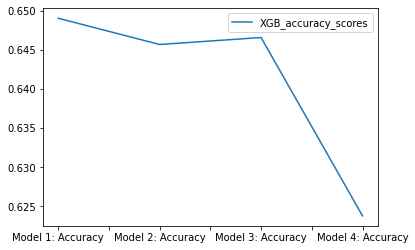

In [154]:
accuracy.plot()
plt.show()

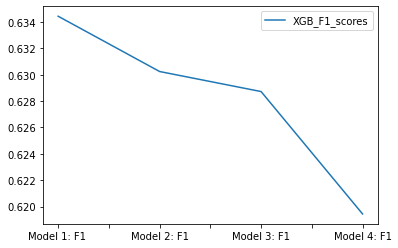

In [153]:
F1.plot()
plt.show()